# llc4320 drifters spectra: Lagrangian vs Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6061139.datarmor0/parcels-502027/libparcels_random_9a43a4b8-abb2-4b0b-807b-540ec9cdd05e.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [4]:
client

Client Scheduler: tcp://10.148.0.37:56087 Dashboard: http://10.148.0.37:8787/status,Cluster Workers: 14 Cores: 28 Memory: 111.72 GiB


________
# Read zonally-averaged LLC4320 spectra 
## (1) both Lag. and Eul.
## (2) as a function of lat

In [5]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [10]:
ds_L_bin = (p.load_diagnostic('spectra_uv_T60_mean0_lat_from_2Dbinned_spectra.zarr')
            .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
           )
ds_L_bin

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 100), meta=np.ndarray>

In [7]:
# load raw spectra
ds_L = (p.load_diagnostic('spectra_uv_T60_mean0_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

ds_E = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat.zarr'))
        .rename({'E_SSUV_T60': 'E_Eulerian', 'lat_bin': 'lat'})
       )

ds = xr.merge([ds_L, ds_E])
ds

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 720), meta=np.ndarray>
    E_Eulerian    (frequency, lat) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

In [8]:
# load spectra (with detrending)
ds_L_nomean = (p.load_diagnostic('spectra_uv_T60_mean1_lat.zarr')
        .rename({'E':'E_Lagrangian', 'lat_bins': 'lat'})
       )

ds_E_nomean = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_nomean_lat.zarr'))
        .rename({'E_SSUV_T60_nomean': 'E_Eulerian', 'lat_bin': 'lat'})
       )

ds_nomean = xr.merge([ds_L_nomean, ds_E_nomean])
ds_nomean

<xarray.Dataset>
Dimensions:       (frequency: 1440, lat: 119)
Coordinates:
  * frequency     (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
Data variables:
    E_Lagrangian  (lat, frequency) float64 dask.array<chunksize=(60, 720), meta=np.ndarray>
    E_Eulerian    (frequency, lat) float64 dask.array<chunksize=(1440, 119), meta=np.ndarray>

## Plots of rotary spectra

Text(0.5, 1.0, 'LLC4320(Eulerian)/LLC4320(Lagrangian,2D binned)')

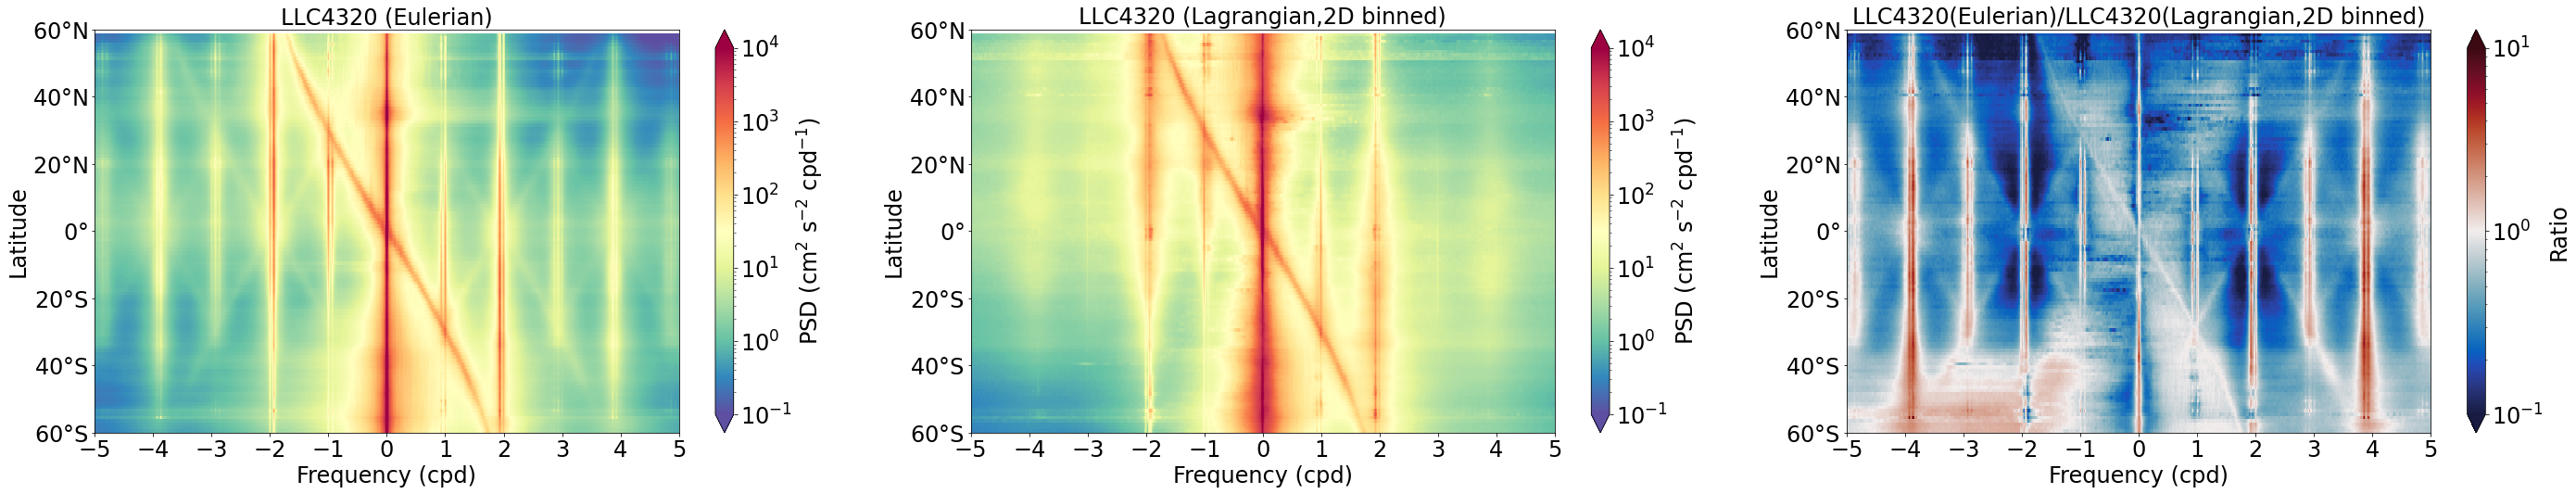

In [15]:
font_size = 24
fig, ax = plt.subplots(figsize=(48,8))

# LLC4320 Eulerian
ax = plt.subplot(1,3,1)
cax = (ds['E_Eulerian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)

# LLC420 Lagrangian
ax = plt.subplot(1,3,2)
cax = (ds_L_bin['E_Lagrangian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
ax.set_title('LLC4320 (Lagrangian,2D binned)',fontsize=font_size)

# Ratio
ax = plt.subplot(1,3,3)
cax = (ds['E_Eulerian']/ds_L_bin['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Lagrangian,2D binned)',fontsize=font_size)

#plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_comparison.png')

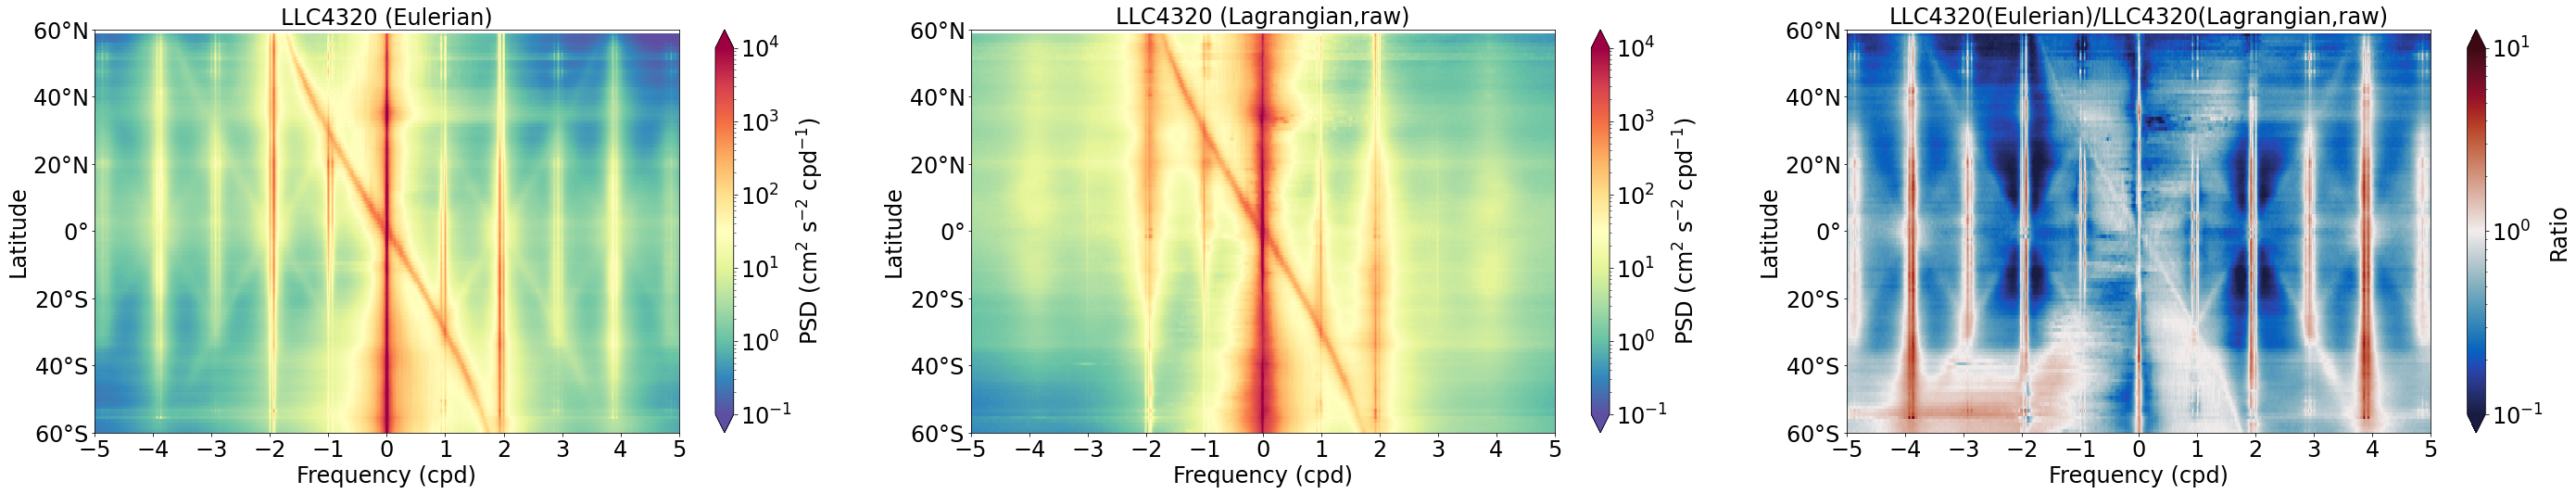

In [11]:
font_size = 24
fig, ax = plt.subplots(figsize=(48,8))

# LLC4320 Eulerian
ax = plt.subplot(1,3,1)
cax = (ds['E_Eulerian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (Eulerian)',fontsize=font_size)

# LLC420 Lagrangian
ax = plt.subplot(1,3,2)
cax = (ds['E_Lagrangian']*86400/6).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap = 'Spectral_r', norm=colors.LogNorm(vmin=1e-1, vmax=1e4), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
ax.set_title('LLC4320 (Lagrangian,raw)',fontsize=font_size)

# Ratio
ax = plt.subplot(1,3,3)
cax = (ds['E_Eulerian']/ds['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Lagrangian,raw)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_comparison.png')

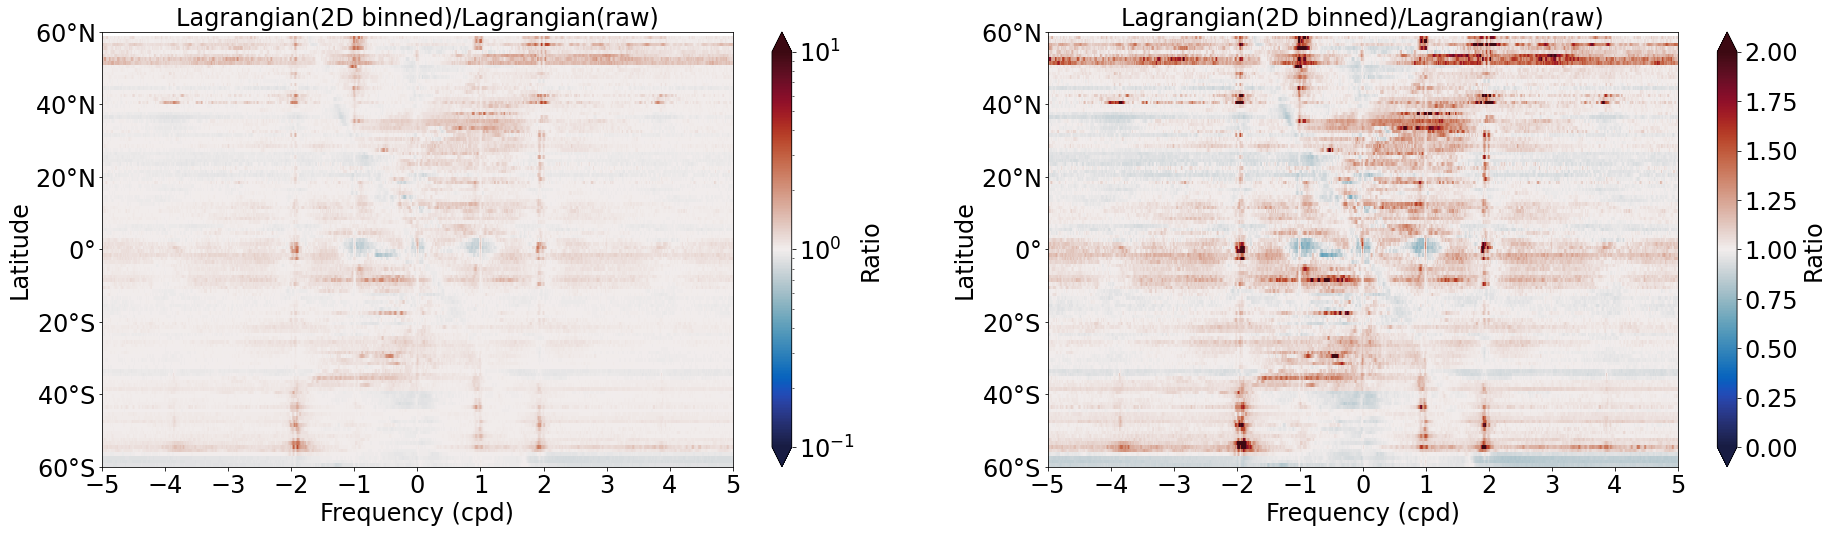

In [9]:
font_size = 24
fig, ax = plt.subplots(figsize=(48,8))

ax = plt.subplot(1,3,1)
cax = (ds_L_bin['E_Lagrangian']/ds['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian(2D binned)/Lagrangian(raw)',fontsize=font_size)

ax = plt.subplot(1,3,2)
cax = (ds_L_bin['E_Lagrangian']/ds['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, vmin=0, vmax=2, add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian(2D binned)/Lagrangian(raw)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_Lagrangian_comparison.png')

Text(0.5, 1.0, 'LLC4320(Lagrangian)/LLC4320(Lagrangian-nomean)')

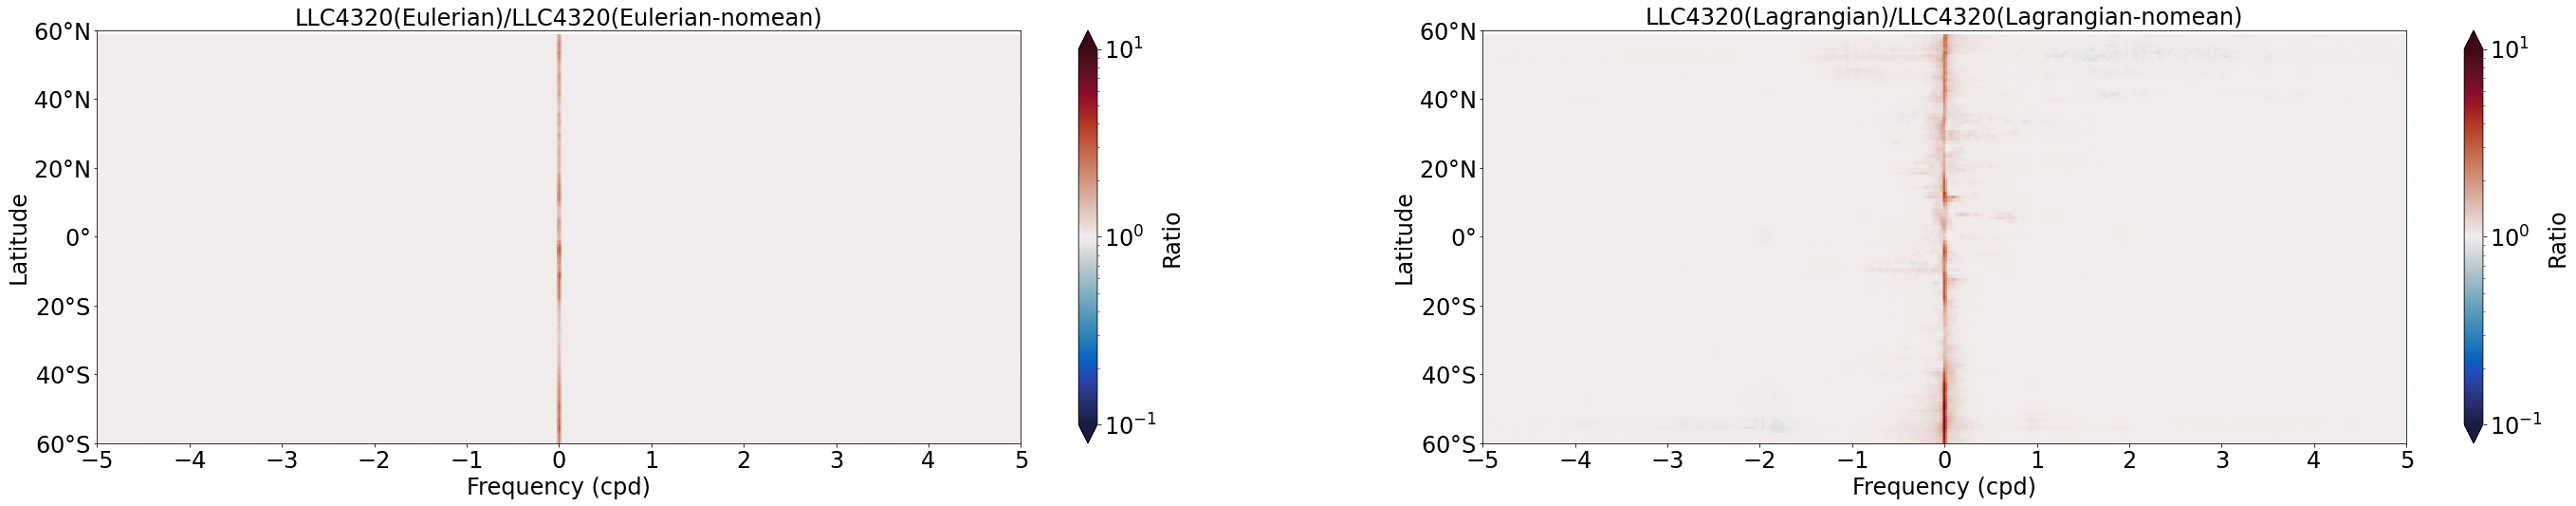

In [10]:
font_size = 24
fig, ax = plt.subplots(figsize=(48,8))

# Eulerian Ratio
ax = plt.subplot(1,2,1)
cax = (ds['E_Eulerian']/ds_nomean['E_Eulerian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Eulerian)/LLC4320(Eulerian-nomean)',fontsize=font_size)

# Lagrangian Ratio
ax = plt.subplot(1,2,2)
cax = (ds['E_Lagrangian']/ds_nomean['E_Lagrangian']).plot.pcolormesh(ax=ax, x='frequency', y='lat', cmap=cm.balance, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320(Lagrangian)/LLC4320(Lagrangian-nomean)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Rotary_spectra_LLC_nomean_comparison.png')

In [11]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
